In [1]:
# prompt: Write code that will read .npy files in the same folder on my drive

# from google.colab import drive
import numpy as np
import os

# Mount Google Drive
# drive.mount('/content/drive')

# Specify the folder path on your Drive
# folder_path = '/content/drive/MyDrive/Colab_Notebooks/ML_Project'  # Replace with your folder path
# folder_path = '/content/drive/MyDrive/PengResearch/ML_Project'  # Replace with your folder path
folder_path = '/home/yesyessp/MLProject/data1'

# Loop through all files in the folder
for filename in os.listdir(folder_path):
  if filename.endswith('.npy'):
    file_path = os.path.join(folder_path, filename)
    try:
      data = np.load(file_path)
      print(f"Found data in {filename}:")
      # print(data)  # Or process the data as needed
    except Exception as e:
      print(f"Error loading {filename}: {e}")
# Load the data collected
TIME = np.load(os.path.join(folder_path, 'TIME.npy'))
U = np.load(os.path.join(folder_path, 'U_data.npy'))
print(U[0,:])
Y = np.load(os.path.join(folder_path, 'Y_matrix.npy'))
delta = Y[:,0:6]*np.pi/180  # Convert degrees to radians
omega = Y[:,6:12]
theta = Y[:,12:12+23]*np.pi/180  # Convert degrees to radians
V = Y[:,12+23:12+23+23]

Y_new = np.hstack((delta, omega, theta, V))
X = np.hstack(( TIME, U))


X_norm = (X - np.mean(X,axis=0))/np.std(X,axis=0)
mu_x = np.mean(X,axis=0)[1:]
sigma_x = np.std(X,axis=0)[1:]
# cast mean and std to float32
mu_x = mu_x.astype(np.float32)
sigma_x = sigma_x.astype(np.float32)
X_norm[:,0]=X[:,0]

Y_norm = (Y_new - np.mean(Y_new,axis=0))/np.std(Y_new,axis=0)
mu_y = np.mean(Y_new,axis=0)
sigma_y = np.std(Y_new,axis=0)
# cast mean and std to float32
mu_y = mu_y.astype(np.float32)
sigma_y = sigma_y.astype(np.float32)



Found data in X_DATA.npy:
Found data in TIME.npy:
Found data in X0.npy:
Found data in Y_matrix.npy:
Found data in U_data.npy:
[ 112.28518545  638.85519599  425.90351815  310.35293964 1264.15612287
  100.50809522  207.49006294  208.58662549  -56.51201767 -510.17009019
 -396.79890906 -160.53156224 -776.84976018  -50.50938217  -80.72274487
  -81.57822972]


In [2]:
print(Y[0,15])

-1.116537094116211


In [3]:
import matplotlib.pyplot as plt

X_plot = X[:802,:];
Y_plot = Y[:802,:];
print(X_plot.shape)
print(Y_plot.shape)

time = X_plot[:,0]
i=0
# print(Y[i*len(time):(i+1)*len(time),10])
# for j in range(0,23):
#   for i in range(0,500):
#       plt.plot(time,Y[i*len(time):(i+1)*len(time),j])
#   plt.title("Delta "+str(j+1))
  # plt.show()

(802, 17)
(802, 58)


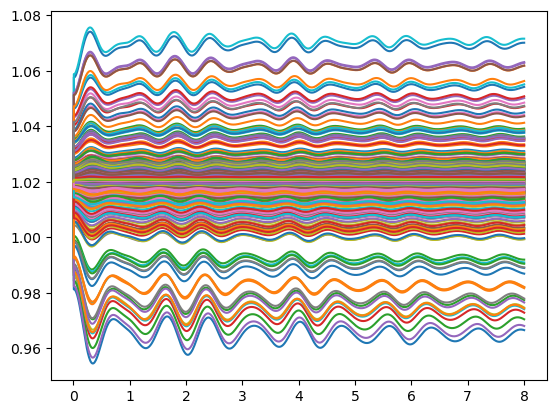

In [4]:
for i in range(1,300):
    plt.plot(time,Y[i*len(time):(i+1)*len(time),36])
# plt.title("Delta "+str(j+1))
plt.show()

In [5]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming X and Y are already loaded as NumPy arrays

# 1. Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y_norm, test_size=0.20, shuffle=False)  # Adjust test_size and random_state as needed

# 2. Create and train the Linear Regression model
model_lin = LinearRegression()
model_lin.fit(X_train, Y_train)

# 3. Make predictions on the test set
Y_pred = model_lin.predict(X_test)

# 4. Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Assuming X and Y are your data matrices
# Add a column of ones to X for the intercept term
X_train_new = np.c_[X_train, np.ones(X_train.shape[0])]
print("The shape of X_train ",X_train_new.shape)
# Calculate the weights using the least squares formula
coefficients = np.linalg.lstsq(X_train_new, Y_train, rcond=None)[0]
# Print the coefficients
# print("Coefficients:", coefficients)
print("The shape of W", coefficients.shape)

print("The shape of X_test", X_test.shape)
X_test_new = np.c_[X_test, np.ones(X_test.shape[0])]

Y_pred = np.dot(X_test_new, coefficients)
print("The shape of Y_pred", Y_pred.shape)

mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")



Mean Squared Error: 0.27255960285403397
R-squared: 0.6857018075047445
The shape of X_train  (641600, 18)
The shape of W (18, 58)
The shape of X_test (160400, 17)
The shape of Y_pred (160400, 58)
Mean Squared Error: 0.2725596028540228
R-squared: 0.6857018075047575


In [ ]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Uncomment this line to force CPU usage

import tensorflow as tf
print("Available devices:", tf.config.list_physical_devices())
import time

# Enable XLA optimization
tf.config.optimizer.set_jit(True)
# no need, the X train and X test are already normalized
# from sklearn.preprocessing import StandardScaler

# scaler_X = StandardScaler()
# X_train = scaler_X.fit_transform(X_train)
# X_test = scaler_X.transform(X_test)

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ Using GPU:", gpus[0])
else:
    print("⚠️ No GPU detected, using CPU")

# Define a deeper & wider model to utilize GPU
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(Y.shape[1])  # No activation for regression
])

# Define optimizer with gradient clipping
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3, clipnorm=1.0)

# Compile the model with Huber loss
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.Huber(delta=1.0),
              metrics=['mse'])

# Start timing
start_time = time.time()
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
print("Available devices:", tf.config.list_physical_devices())
# Train on GPU with large batch size
# with tf.device('/GPU:0'):
#     model.fit(X_train, Y_train, epochs=300, batch_size=1024, verbose=1)

model.fit(X_train, Y_train, epochs=300, batch_size=1024, verbose=1)
# End timing
end_time = time.time()

print(f"⏱️ Training completed in {end_time - start_time:.2f} seconds")

# Evaluate
loss = model.evaluate(X_test, Y_test)
model.save("OF_King_mini_MSE.h5")
print("Test Loss:", loss)


2025-05-04 18:35:03.663391: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 18:35:03.693476: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-04 18:35:04.116203: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-05-04 18:35:04.619331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2025-05-04 18:35:04.663761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-04 18:35:04.663793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-04 18:35:04.663803: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2048] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2025-05-04 18:35:04.672040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-04 18:35:04.672077

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/300


2025-05-04 18:35:05.467350: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1780] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).
2025-05-04 18:35:06.085107: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x1deabfb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-04 18:35:06.085136: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 5070 Ti, Compute Capability 12.0
2025-05-04 18:35:06.092913: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set 

627/627 [==============================] - 5s 5ms/step - loss: 0.0981 - mse: 0.2253
Epoch 2/300
 23/627 [>.............................] - ETA: 2s - loss: 0.0637 - mse: 0.1317

2025-05-04 18:35:10.626895: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


627/627 [==============================] - 3s 5ms/step - loss: 0.0609 - mse: 0.1260
Epoch 3/300
627/627 [==============================] - 3s 4ms/step - loss: 0.0548 - mse: 0.1128
Epoch 4/300
627/627 [==============================] - 3s 4ms/step - loss: 0.0520 - mse: 0.1067
Epoch 5/300
627/627 [==============================] - 3s 4ms/step - loss: 0.0501 - mse: 0.1027
Epoch 6/300
627/627 [==============================] - 3s 4ms/step - loss: 0.0488 - mse: 0.0999
Epoch 7/300
627/627 [==============================] - 3s 4ms/step - loss: 0.0478 - mse: 0.0979
Epoch 8/300
627/627 [==============================] - 2s 4ms/step - loss: 0.0465 - mse: 0.0953
Epoch 9/300
627/627 [==============================] - 2s 4ms/step - loss: 0.0455 - mse: 0.0931
Epoch 10/300
627/627 [==============================] - 2s 4ms/step - loss: 0.0443 - mse: 0.0909
Epoch 11/300
627/627 [==============================] - 2s 4ms/step - loss: 0.0432 - mse: 0.0886
Epoch 12/300
627/627 [============================

In [ ]:

model.save("OF_King_mini_MSE.keras")
model.save("OF_King_mini_MSE.h5")


6
26/26 [==============================] - 0s 1ms/step
(802, 58)
[4.22037280e+01 4.22037280e+01 1.87830249e+01 3.66315785e+01
 1.71993937e+01 2.02902652e+01 1.62998909e-04 1.62998909e-04
 1.62878788e-04 1.62993942e-04 1.62760757e-04 1.62947927e-04
 2.91883830e+01 2.91883830e+01 2.35333306e+01 1.15236384e+01
 9.40431129e+00 2.75109621e+00 1.88038382e+01 1.13198483e+01
 5.70897011e+00 8.90372972e+00 3.45265606e+00 9.66112583e+00
 2.55627967e+01 1.12627770e+01 1.08103196e+01 1.03818572e+01
 9.20669504e+00 7.45490085e+00 8.84632006e+00 4.09522269e+00
 3.59392179e+00 1.26352375e+01 8.56465625e+00 1.02007817e+00
 1.02007817e+00 1.01197569e+00 1.01717672e+00 9.93699501e-01
 9.39665678e-01 1.04012412e+00 1.00895634e+00 9.66863910e-01
 9.79186147e-01 9.49681333e-01 1.02411840e+00 1.04043214e+00
 1.02994513e+00 1.02808255e+00 1.02351929e+00 1.01671711e+00
 9.95121177e-01 9.94639810e-01 9.64124242e-01 9.59200352e-01
 1.04008399e+00 1.02224063e+00]
[1.98332470e+02 1.98332470e+02 1.99667199e+02 1.9

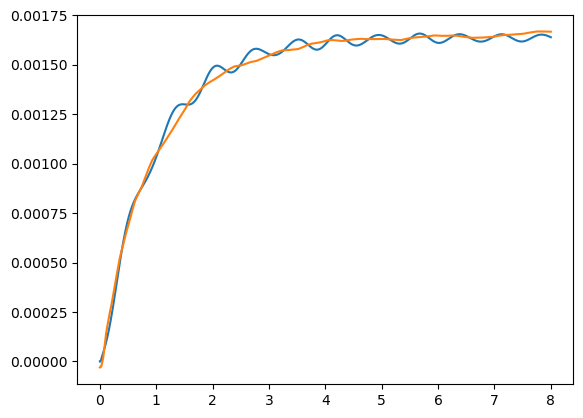

In [9]:
case_num = 1
Ngen = 6
Nbus = 23
# delta --> var_plot = 1
# omega --> var_plot = 2
# theta --> var_plot = 3
#   V   --> var_plot = 4
var_plot = 2

gen_plot = 1
bus_plot = 1


idx = (var_plot==1)*(gen_plot-1) + (var_plot==2)*(gen_plot+Ngen-1) + (var_plot==3)*(bus_plot+2*Ngen-1) + (var_plot==4)*(bus_plot+2*Ngen+Nbus-1)
print(idx)
X_plot = X_norm[802*(case_num-1):802*case_num,:];
Y_plot = Y[802*(case_num-1):802*case_num,:];

time = X_plot[:,0]

Y_pred = model.predict(X_plot)
print(Y_pred.shape)
mu_y = np.mean(Y,axis=0)
sigma_y = np.std(Y,axis=0)
print(mu_y)
print(sigma_y)
Y_pred = Y_pred*sigma_y+mu_y
print(Y_pred.shape)
plt.plot(time,Y_plot[:,idx])
plt.plot(time,Y_pred[:,idx])
# plt.plot(time,np.mean(Y_plot,axis=0)[10]*np.ones(time.shape))
plt.show()


26/26 [==============================] - 0s 1ms/step


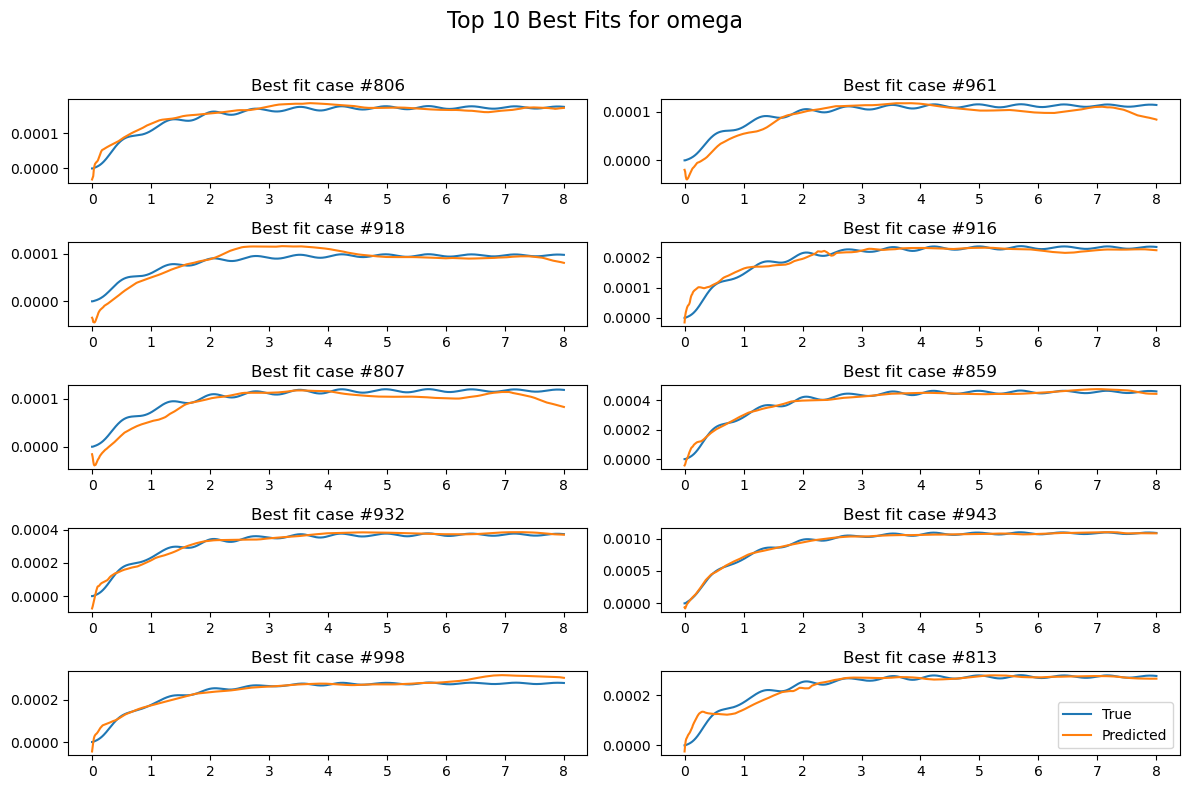

26/26 [==============================] - 0s 1ms/step


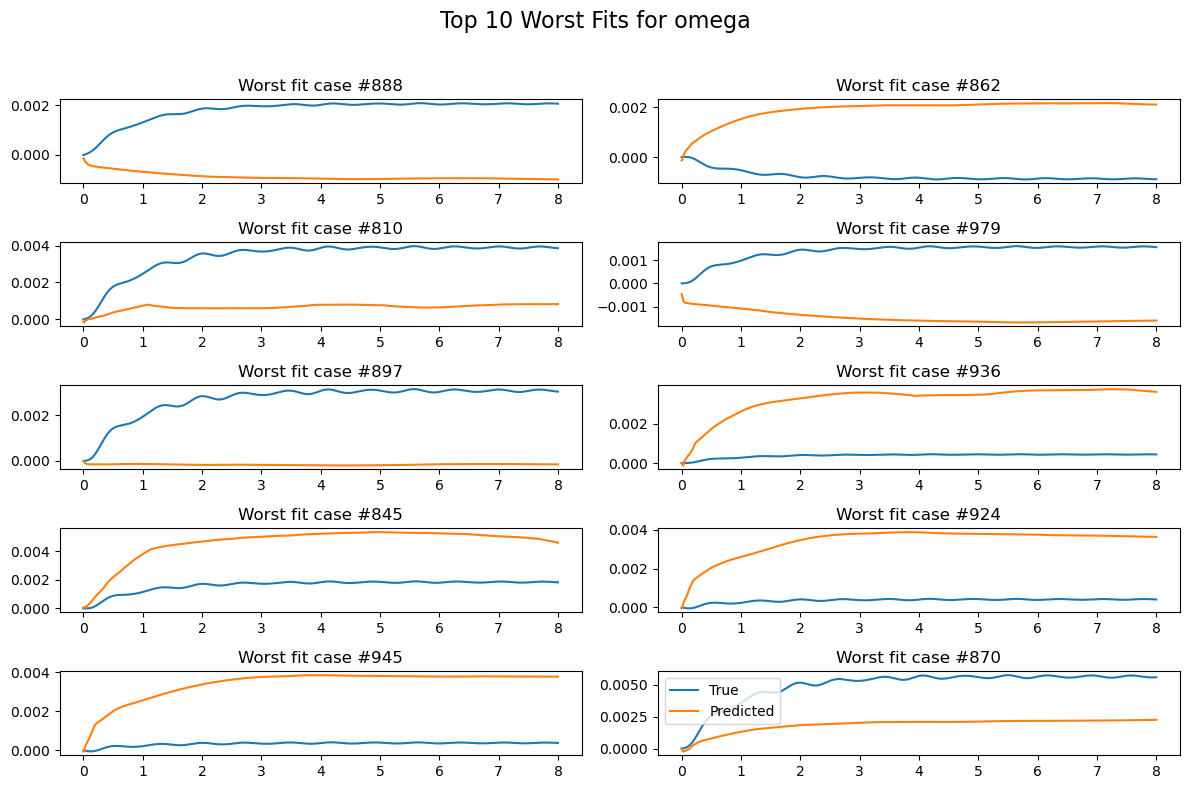

In [10]:
import numpy as np
import matplotlib.pyplot as plt

Ncases = Y.shape[0] // 802
errors = []

# Compute prediction errors for all cases
for case in range(800, 1000): # 1000 cases in total 
    X_plot = X_norm[802*(case-1):802*case, :]
    Y_plot_case = Y[802*(case-1):802*case, :]

    Y_pred_case = model.predict(X_plot)
    Y_pred_case = Y_pred_case * sigma_y + mu_y

    error = np.mean((Y_pred_case[:, idx] - Y_plot_case[:, idx])**2)
    errors.append((case, error))

# Sort by error
errors_sorted = sorted(errors, key=lambda x: x[1])
best_cases = [e[0] for e in errors_sorted[:10]]
worst_cases = [e[0] for e in errors_sorted[-10:]]

# Plot best fits
plt.figure(figsize=(12, 8))
for i, case in enumerate(best_cases):
    X_plot = X_norm[802*(case-1):802*case, :]
    Y_plot_case = Y[802*(case-1):802*case, :]
    time = X_plot[:, 0]

    Y_pred_case = model.predict(X_plot)
    Y_pred_case = Y_pred_case * sigma_y + mu_y

    plt.subplot(5, 2, i+1)
    plt.plot(time, Y_plot_case[:, idx], label='True')
    plt.plot(time, Y_pred_case[:, idx], label='Predicted')
    plt.title(f'Best fit case #{case}')
    plt.tight_layout()
plt.legend()
plt.suptitle('Top 10 Best Fits for omega', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plot worst fits
plt.figure(figsize=(12, 8))
for i, case in enumerate(worst_cases):
    X_plot = X_norm[802*(case-1):802*case, :]
    Y_plot_case = Y[802*(case-1):802*case, :]
    time = X_plot[:, 0]

    Y_pred_case = model.predict(X_plot)
    Y_pred_case = Y_pred_case * sigma_y + mu_y

    plt.subplot(5, 2, i+1)
    plt.plot(time, Y_plot_case[:, idx], label='True')
    plt.plot(time, Y_pred_case[:, idx], label='Predicted')
    plt.title(f'Worst fit case #{case}')
    plt.tight_layout()
plt.legend()
plt.suptitle('Top 10 Worst Fits for omega', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
